## Predicting Car Collision Type by Road Condition Based on Montgomery County Data

---








"Authors: Dominic Sagen, Dylan Masters, Siya Dharmendra Adrekar"

Date: December 10th, 2022

## Introduction

In this report, we will be looking at collision data from Montgomery County, Maryland. We will be exploring whether certain road conditions (weather, speed limit, surface condition, etc) are more likely to cause a rear end car accident vs any other type of crash. We will be using the values in this dataset which show the conditions of the road in order to predict the type of accident which occurs.


"This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County. This dataset shows each collision data recorded and the drivers involved."




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz
import warnings
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chisquare, chi2_contingency

In [ ]:
sns.set()
rcParams['figure.figsize'] = 10,6
sns.set_context('talk')
sns.set_style('whitegrid')

In [ ]:
#Disabiling the warnings
warnings.filterwarnings('ignore')

#### Definitions


In [ ]:
def plot_tree_custom(clf):
    target_names = ['OTHER', 'SAME DIR']
    dot_data = export_graphviz(clf, precision=2,
                         feature_names=predictors,
                         proportion=True,
                         class_names=target_names,
                         filled=True, rounded=True,
                         special_characters=True)

    graph = graphviz.Source(dot_data)
    return graph

In [ ]:
def plot_learning_curve(clf, X_train, y_train):
    # generate the data; average the values
    train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve, classification tree')
    plt.legend();

In [ ]:
def forward_selection_classif(clf, X, y, threshold=None, num_folds=5):
    """ Perform forward feature selection with the given classifier.
    Threshold is the improvement in accuracy for the selection
    process to stop.
    threshold = None causes all features to be selected.
    """

    remaining = list(range(X.shape[1]))
    selected = []
    accuracies = []
    previous_best = 0.0
    while len(remaining) > 0:

        # YOUR CODE HERE
        # Use cross validation accuracy in computing the accuracy.
        # Use cross_val_score() to perform cross validation.
        # Use parameter num_folds to control the number of folds in cross validation.
        # cross_val_score() returns multiple values; you need to get the mean of the values.
        # To test if the value of threshold is not None, you can write 'threshold is not None'
        best_i, best_accuracy = 0, 0.0
        for i in remaining:
            accuracy = cross_val_score(clf, X[:,selected+[i]], y, cv=num_folds).mean()
            # print('predictors: {}: accuracy: {:.3f}'.format(np.array(predictors)[np.array(selected+[i])], accuracy))
            if accuracy > best_accuracy:
                best_i, best_accuracy = i, accuracy

        if (threshold is not None) and (best_accuracy - previous_best) < threshold:
            break
        selected.append(best_i)
        accuracies.append(best_accuracy)
        remaining.remove(best_i)
        previous_best = best_accuracy
    return np.array(selected), accuracies

In [ ]:
def plot_selected(selected, accuracies, predictors):
    pd.Series(accuracies, index=predictors[selected]).plot.barh()
    plt.xlim(0.5, 1.0)
    plt.xlabel('Cross-validation accuracy')
    plt.title('Result of forward feature selection')

## Initial Data Exploration

The first step is to read in the data from the CSV file provided.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/SiyaAdrekar/dataset/main/Crash_Reporting_Drivers_Data.csv')

We will now take a moment to examine the data.

The orignal dataset contains 150895 rows and 43 columns.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150895 entries, 0 to 150894
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   150895 non-null  object 
 1   Local Case Number               150895 non-null  object 
 2   Agency Name                     150895 non-null  object 
 3   ACRS Report Type                150895 non-null  object 
 4   Crash Date/Time                 150895 non-null  object 
 5   Route Type                      136133 non-null  object 
 6   Road Name                       136930 non-null  object 
 7   Cross-Street Type               136109 non-null  object 
 8   Cross-Street Name               136925 non-null  object 
 9   Off-Road Description            13963 non-null   object 
 10  Municipality                    16725 non-null   object 
 11  Related Non-Motorist            4739 non-null    object 
 12  Collision Type  

In [ ]:
df.shape

(150895, 43)

In [ ]:
df.describe().round(3)

,Speed Limit,Vehicle Year,Latitude,Longitude
count,150895.000,150895.000,150895.000,150895.000
mean,32.674,1966.954,39.083,-77.112
std,11.068,338.794,0.072,0.099
min,0.000,0.000,37.720,-79.486
25%,30.000,2005.000,39.024,-77.189
50%,35.000,2011.000,39.075,-77.105
75%,40.000,2015.000,39.139,-77.040
max,70.000,9999.000,39.990,-75.528


#### Target variable information

Before we investigate anything else, we should take a look at the variable we are trying to predict: `Collision Type`.

In [ ]:
df['Collision Type'].value_counts()

SAME DIR REAR END               49582
STRAIGHT MOVEMENT ANGLE         26317
OTHER                           16668
SINGLE VEHICLE                  13971
SAME DIRECTION SIDESWIPE        13936
HEAD ON LEFT TURN               11280
HEAD ON                          3313
SAME DIRECTION RIGHT TURN        3294
SAME DIRECTION LEFT TURN         3248
OPPOSITE DIRECTION SIDESWIPE     2500
ANGLE MEETS LEFT TURN            1754
ANGLE MEETS RIGHT TURN           1056
SAME DIR REND LEFT TURN           671
SAME DIR REND RIGHT TURN          668
UNKNOWN                           625
ANGLE MEETS LEFT HEAD ON          618
SAME DIR BOTH LEFT TURN           601
OPPOSITE DIR BOTH LEFT TURN       290
Name: Collision Type, dtype: int64

In [ ]:
df['Collision Type'].isna().mean()

0.0033334437854136982

Collision Type has a variety of possibilities that can happen for a crash. `OTHER` might be a complicated variable to work with because of how vague that is. There is also a lot of different variables that could be combined into a single variable, such as anything with `SAME DIRECTION`, `ANGLE`, and `HEAD ON` respectively. We should investigate this further when we process the data.

Please note that there are very few NA values present within Collision Type, but `UNKNOWN` and `OTHER` could be interpreted as bad data here that we can't use for our training.

#### Possibilites for predictor variables

The next thing we should do is look for certain columns that contain information which could prove vital to our machine learning process. Here is a list of noteworthy predictors for Collision Type, so we'll need to investigate and process each as needed:
- `Crash Date/Time` - Does a certain day or time of day have a higher chance of certain Collision Types? We will not be using this column because it would require a lot of processing for information that's not meaningful enough to the target variable.

- `Road Name` - Does a certan road have a higher chance of certain Collision Types? We will not be using this column because it can be heavily affected by road length and how busy it gets, and it doesn't really give us meaningful information for certain Collision Types.

- `Weather` - Do weather conditions affect the chances of certain Collision Types happening?

- `Surface Condition` - Do the conditions of the road affect the chances of certain Collision Types happening?

- `Light` - Do certain Collision Types happen more frequently with daylight vs at night or when it is dark?

- `Traffic Control` - Does the location of where this Collision occurred influence the type of Collision that happens?

- `Driver Substance Abuse` - Does driving under the influence of alcohol, or some other substance, affect the chances of certain Collision Types?

- `Drivers License State` - Do people with a license from a certain state affect the kind of Collision Type they get into? We will not be using this column because this seems irrelevant to Collision Type.

- `Vehicle Body Type` - Does the car having a particular body type affect the kind of Collision Type they get into?

- `Speed Limit` - Does the Speed Limit of the road affect the type of Collision that occurs?

- `Equipment Problems` - Are certain Collision Types more likely if there are particular Equipment Problems?

Please note that we also considered `Driver at Fault` and `Driver Distracted By`, but dropped them from initial data exploration since they were variables we would only be able to track after the collision had already happened.

#### First look at missing data

Finally, we should check how much missing data is included within this dataset. While we do not know if NA values make up all bad data that may be found here, it does provide a foundation for our data processing. Please note that not all columns contain NA values, which could mean they are necessary for the reporting, easy to fill in, or contain a specific response for invalid data rather than being left blank.

In [ ]:
(df.isna().sum().sum())

873956

In [ ]:
df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False)

Non-Motorist Substance Abuse      147138
Related Non-Motorist              146156
Off-Road Description              136932
Municipality                      134170
Circumstance                      123113
Equipment Problems                 31037
Driver Substance Abuse             27441
Traffic Control                    22879
Surface Condition                  17717
Cross-Street Type                  14786
Route Type                         14762
Cross-Street Name                  13970
Road Name                          13965
Weather                            11824
Drivers License State               8224
Vehicle Continuing Dir              2344
Vehicle Going Dir                   2344
Vehicle Body Type                   2301
Light                               1267
Collision Type                       503
Vehicle Movement                     319
Vehicle Damage Extent                271
Vehicle Second Impact Location       256
Vehicle First Impact Location        156
Vehicle Model   

This dataset contains a vast amount of NA values, and considering we have only 150 thousand rows, we currently have a ratio of nearly 6 NA values to 1 row of data. We can also infer that certain columns have a much greater amount of NA values than others, so let's investigate these columns further.

In [ ]:
df.isna().mean()[df.isna().mean()>0].sort_values(ascending=False).head(10)

Non-Motorist Substance Abuse    0.975102
Related Non-Motorist            0.968594
Off-Road Description            0.907465
Municipality                    0.889161
Circumstance                    0.815885
Equipment Problems              0.205686
Driver Substance Abuse          0.181855
Traffic Control                 0.151622
Surface Condition               0.117413
Cross-Street Type               0.097989
dtype: float64

A majority of the NA values belong to 5 columns, but we are not considering those for predictor variables. However, there are four columns that we are considering which are shown to have 10-21% of their data as NA values. We could impute the most common value for Surface Condition, but we should only choose one of the other 3 columns to prevent too much data being lost. Since Traffic Control is only about 15% of the data, we've decided to keep that.


In conclusion, we know a little bit more about our target variable `Collision Type`, and we are left with these predictor variables for data cleaning: "Weather", "Surface Condition", "Light", "Traffic Control", "Vehicle Body Type", "Speed Limit".

## Data cleaning and preprocessing

Now that we've identified the variables we want to potentially use for our machine learning algorithms, all of the other columns can be removed from out dataset.

In [ ]:
vars = ['Collision Type', 'Weather', 'Surface Condition', 'Light', 'Traffic Control','Vehicle Body Type', 'Speed Limit']
df = df[df.columns[df.columns.isin(vars)]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150895 entries, 0 to 150894
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Collision Type     150392 non-null  object
 1   Weather            139071 non-null  object
 2   Surface Condition  133178 non-null  object
 3   Light              149628 non-null  object
 4   Traffic Control    128016 non-null  object
 5   Vehicle Body Type  148594 non-null  object
 6   Speed Limit        150895 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 8.1+ MB


#### Processing our target variable

Let's process each of these columns individually to make sure we remove any bad or misleading data from our dataset. First, we should look at our target variable: `Collision Type`. From the initial data exploration stage, we already know that there is a lot of data we can consider similar enough to be in the same value type, so we should be able to process this column significantly.

In [ ]:
df['Collision Type'].value_counts()

SAME DIR REAR END               49582
STRAIGHT MOVEMENT ANGLE         26317
OTHER                           16668
SINGLE VEHICLE                  13971
SAME DIRECTION SIDESWIPE        13936
HEAD ON LEFT TURN               11280
HEAD ON                          3313
SAME DIRECTION RIGHT TURN        3294
SAME DIRECTION LEFT TURN         3248
OPPOSITE DIRECTION SIDESWIPE     2500
ANGLE MEETS LEFT TURN            1754
ANGLE MEETS RIGHT TURN           1056
SAME DIR REND LEFT TURN           671
SAME DIR REND RIGHT TURN          668
UNKNOWN                           625
ANGLE MEETS LEFT HEAD ON          618
SAME DIR BOTH LEFT TURN           601
OPPOSITE DIR BOTH LEFT TURN       290
Name: Collision Type, dtype: int64

We can observe roughly 6 categories from these value names:
- Same direction crashes - Usually results in a rear end
- Head on collisions - Opposite direction accidents
- Angled crashes - Usually a T-bone or something similar
- Single vehicle - When a vehicle crashes on the side of the road
- Other - Something that isn't one of these 4 categories (Not really sure what that would be)
- Unknown / NA - Data that is invalid and we should get rid of

Let's combine all the values into the first 5 categories and get rid of the Unknown / NA values.

In [ ]:
df['Collision Type'].replace('UNKNOWN', np.nan, inplace=True)
df_test_collision = df.copy()
df_test_collision['Collision Type'].replace({'SAME DIR BOTH LEFT TURN': 'SAME DIR', 'SAME DIRECTION LEFT TURN' : 'SAME DIR', 'SAME DIRECTION RIGHT TURN': 'SAME DIR', 'SAME DIRECTION SIDESWIPE': 'SAME DIR', 'SAME DIR REAR END': 'SAME DIR', 'SAME DIR REND LEFT TURN': 'SAME DIR', 'SAME DIR REND RIGHT TURN': 'SAME DIR'}, inplace=True)
df_test_collision['Collision Type'].replace({'ANGLE MEETS LEFT HEAD ON' : 'HEAD ON', 'HEAD ON LEFT TURN': 'HEAD ON', 'OPPOSITE DIR BOTH LEFT TURN': 'HEAD ON', 'OPPOSITE DIRECTION SIDESWIPE': 'HEAD ON', }, inplace=True)
df_test_collision['Collision Type'].replace({'ANGLE MEETS LEFT TURN': 'ANGLE', 'ANGLE MEETS RIGHT TURN' :'ANGLE',  'STRAIGHT MOVEMENT ANGLE': 'ANGLE', }, inplace=True)
df_test_collision['Collision Type'].value_counts()

SAME DIR          72000
ANGLE             29127
HEAD ON           18001
OTHER             16668
SINGLE VEHICLE    13971
Name: Collision Type, dtype: int64

This has resulted in a skewed representation towards same direction crashes. What if we combine them based on a slightly different set of categories instead?

- Rear End
- Head On / Opposite Direction
- Single
- Other

In [ ]:
df_test_collision_2 = df.copy()
df_test_collision_2['Collision Type'].replace({'SAME DIR REAR END': 'REAR END', 'SAME DIR REND LEFT TURN': 'REAR END', 'SAME DIR REND RIGHT TURN': 'REAR END'}, inplace=True)
df_test_collision_2['Collision Type'].replace({'ANGLE MEETS LEFT HEAD ON' : 'HEAD ON', 'HEAD ON LEFT TURN': 'HEAD ON', 'OPPOSITE DIR BOTH LEFT TURN': 'HEAD ON', 'OPPOSITE DIRECTION SIDESWIPE': 'HEAD ON', }, inplace=True)
df_test_collision_2['Collision Type'].replace({'ANGLE MEETS LEFT TURN': 'OTHER', 'ANGLE MEETS RIGHT TURN' :'OTHER',  'STRAIGHT MOVEMENT ANGLE': 'OTHER', 'SAME DIR BOTH LEFT TURN': 'OTHER', 'SAME DIRECTION LEFT TURN' : 'OTHER', 'SAME DIRECTION SIDESWIPE': 'OTHER', 'SAME DIRECTION RIGHT TURN': 'OTHER'}, inplace=True)
df_test_collision_2['Collision Type'].value_counts()

OTHER             66874
REAR END          50921
HEAD ON           18001
SINGLE VEHICLE    13971
Name: Collision Type, dtype: int64

This seems closer to what we want, but combining everything into other seems to be a bit too vague, as we would have a lot of outcomes that are the 'else' clause here. For this next attempt, let's try combining the values in this way:

- Rear End
- Head on / Opposite Direction
- Angle / Side
- Other

We are removing Single Vehicle so we can look at car crashes involving multiple cars only.

In [ ]:
df_test_collision_3 = df.copy()
df_test_collision_3['Collision Type'].replace('SINGLE VEHICLE', np.nan, inplace=True)
df_test_collision_3['Collision Type'].replace({'SAME DIR REAR END': 'REAR END', 'SAME DIR REND LEFT TURN': 'REAR END', 'SAME DIR REND RIGHT TURN': 'REAR END'}, inplace=True)
df_test_collision_3['Collision Type'].replace({'ANGLE MEETS LEFT HEAD ON' : 'HEAD ON', 'HEAD ON LEFT TURN': 'HEAD ON', 'OPPOSITE DIR BOTH LEFT TURN': 'HEAD ON', 'OPPOSITE DIRECTION SIDESWIPE': 'HEAD ON', }, inplace=True)
df_test_collision_3['Collision Type'].replace({'ANGLE MEETS LEFT TURN': 'ANGLE', 'ANGLE MEETS RIGHT TURN' :'ANGLE',  'STRAIGHT MOVEMENT ANGLE': 'ANGLE', 'SAME DIR BOTH LEFT TURN': 'ANGLE', 'SAME DIRECTION LEFT TURN' : 'ANGLE', 'SAME DIRECTION SIDESWIPE': 'ANGLE', 'SAME DIRECTION RIGHT TURN': 'ANGLE'}, inplace=True)
df_test_collision_3['Collision Type'].value_counts()

REAR END    50921
ANGLE       50206
HEAD ON     18001
OTHER       16668
Name: Collision Type, dtype: int64

This split seems relatively evened out, but we don't want to get rid of Head On / Other data. Let's try one more test to split it into two distinct possibilites: One for collisions that happen in the `SAME DIRECTION`, and one for any other collision that may happen.

In [ ]:
df_test_collision4 = df.copy()
df_test_collision4['Collision Type'].replace({'SAME DIR BOTH LEFT TURN': 'SAME DIR', 'SAME DIRECTION LEFT TURN' : 'SAME DIR', 'SAME DIRECTION RIGHT TURN': 'SAME DIR', 'SAME DIRECTION SIDESWIPE': 'SAME DIR', 'SAME DIR REAR END': 'SAME DIR', 'SAME DIR REND LEFT TURN': 'SAME DIR', 'SAME DIR REND RIGHT TURN': 'SAME DIR'}, inplace=True)
df_test_collision4['Collision Type'].replace({'ANGLE MEETS LEFT HEAD ON' : 'HEAD ON', 'HEAD ON LEFT TURN': 'HEAD ON', 'OPPOSITE DIR BOTH LEFT TURN': 'HEAD ON', 'OPPOSITE DIRECTION SIDESWIPE': 'HEAD ON', }, inplace=True)
df_test_collision4['Collision Type'].replace({'ANGLE MEETS LEFT TURN': 'ANGLE', 'ANGLE MEETS RIGHT TURN' :'ANGLE',  'STRAIGHT MOVEMENT ANGLE': 'ANGLE', }, inplace=True)
df_test_collision4['Collision Type'].replace({'ANGLE', 'HEAD ON', 'SINGLE VEHICLE'}, 'OTHER', inplace=True)
df_test_collision4['Collision Type'].value_counts()

OTHER       77767
SAME DIR    72000
Name: Collision Type, dtype: int64

This seems like a good split for the data. There are 2 distinct outcomes we can try to predict during our machine learning process. Let's set the dataframe to these values and continue on.

In [ ]:
df = df_test_collision4
df['Collision Type'].value_counts()

OTHER       77767
SAME DIR    72000
Name: Collision Type, dtype: int64

#### Processing predictor variables

With Collision Type cleaned and categorized, it is time to focus our attention on the different predictor variables. Let's investigate Weather first. A majority of the crashes collected in this data set occurred when it was clear weather, which makes sense since that's when a majority of driving takes place. We can maintain `RAINING` and `CLOUDY` since both have a significant amount of data and are fairly distinct from each other. We can also combine the Icy categories into `SNOW` and combine the Blow categories into `SEVERE WINDS`. We can further remove the `UNKNOWN` values from the data set.

In [ ]:
df['Weather'].value_counts()

CLEAR                       101840
RAINING                      18022
CLOUDY                       15449
SNOW                          1421
UNKNOWN                        594
FOGGY                          575
WINTRY MIX                     374
OTHER                          321
SLEET                          202
SEVERE WINDS                   143
BLOWING SNOW                   115
BLOWING SAND, SOIL, DIRT        15
Name: Weather, dtype: int64

In [ ]:
df['Weather'].replace({'BLOWING SNOW' : 'SEVERE WINDS','BLOWING SAND, SOIL, DIRT': 'SEVERE WINDS'}, inplace=True)
df['Weather'].replace({'WINTRY MIX': 'SNOW', 'SLEET': 'SNOW'},inplace=True)
df['Weather'].replace('UNKNOWN', np.nan, inplace=True)
df['Weather'].value_counts()

CLEAR           101840
RAINING          18022
CLOUDY           15449
SNOW              1997
FOGGY              575
OTHER              321
SEVERE WINDS       273
Name: Weather, dtype: int64

The next variable to check is Surface Condition. There's really only 3 distinct categories here, being `DRY`, `WET`, and `SNOW`. We can leave those two alone and remove everything else from our data set.

In [ ]:
df['Surface Condition'].value_counts()

DRY                       105357
WET                        24995
ICE                          988
SNOW                         933
UNKNOWN                      441
SLUSH                        199
OTHER                        158
MUD, DIRT, GRAVEL             44
WATER(STANDING/MOVING)        36
OIL                           23
SAND                           4
Name: Surface Condition, dtype: int64

In [ ]:
df['Surface Condition'].replace({'ICE', 'SLUSH'}, 'SNOW', inplace=True)
df['Surface Condition'].replace({'OTHER', 'MUD, DIRT, GRAVEL', 'WATER(STANDING/MOVING)', 'OIL', 'SAND', 'UNKNOWN'}, np.nan, inplace=True)
df['Surface Condition'].value_counts()

DRY     105357
WET      24995
SNOW      2120
Name: Surface Condition, dtype: int64

The next variable is Light. I think there's enough data in each of these to leave them alone, but we remove the bottom 3 values here since they are a bit vague.

In [ ]:
df['Light'].value_counts()

DAYLIGHT                    102380
DARK LIGHTS ON               34153
DARK NO LIGHTS                4363
DUSK                          3508
DAWN                          2977
DARK -- UNKNOWN LIGHTING      1355
UNKNOWN                        589
OTHER                          303
Name: Light, dtype: int64

In [ ]:
df['Light'].replace({'DARK -- UNKNOWN LIGHTING', 'UNKNOWN', 'OTHER'}, np.nan, inplace=True)
df['Light'].value_counts()

DAYLIGHT          102380
DARK LIGHTS ON     34153
DARK NO LIGHTS      4363
DUSK                3508
DAWN                2977
Name: Light, dtype: int64

Traffic Control is the next variable on our list, and it should be a bit more interesting than the previous few. There are two main categories that we can use:
- `NO CONTROLS` - This means the crash did not happen at a stop of some sort
- `TRAFFIC SIGNAL` - This means the crash happened at or near a traffic stop
- `STOP SIGN` - This means the crash happened at a stop sign. Please note we are considering the `FLASHING TRAFFIC SIGNAL` as equivalent to a stop sign.

We can replace everything else with `OTHER` and remove `UNKNOWN` as usual.

In [ ]:
df['Traffic Control'].value_counts()

NO CONTROLS                59925
TRAFFIC SIGNAL             51261
STOP SIGN                  10916
FLASHING TRAFFIC SIGNAL     1840
OTHER                       1808
YIELD SIGN                  1591
PERSON                       243
UNKNOWN                      232
WARNING SIGN                 148
RAILWAY CROSSING DEVICE       38
SCHOOL ZONE SIGN DEVICE       14
Name: Traffic Control, dtype: int64

In [ ]:
df['Traffic Control'].replace('FLASHING TRAFFIC SIGNAL', 'STOP SIGN', inplace=True)
df['Traffic Control'].replace({'YIELD SIGN', 'PERSON', 'WARNING SIGN', 'RAILWAY CROSSING DEVICE', 'SCHOOL ZONE SIGN DEVICE'}, 'OTHER', inplace=True)
df['Traffic Control'].replace('UNKNOWN', np.nan, inplace=True)
df['Traffic Control'].value_counts()

NO CONTROLS       59925
TRAFFIC SIGNAL    51261
STOP SIGN         12756
OTHER              3842
Name: Traffic Control, dtype: int64

Vehicle Body Type is the most difficult of our predictor variables to process, as there are many different kinds of vehicles that we can investigate. We can immediately cross off anything similar to a motorcycle from the list, since we are only investigating car crashes, as well as `UNKNOWN` vehicles.

In [ ]:
df['Vehicle Body Type'].value_counts()

PASSENGER CAR                                                104355
(SPORT) UTILITY VEHICLE                                       13794
PICKUP TRUCK                                                   6003
VAN                                                            4370
TRANSIT BUS                                                    3175
SCHOOL BUS                                                     2536
POLICE VEHICLE/NON EMERGENCY                                   1850
OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)               1743
CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))      1665
OTHER                                                          1450
POLICE VEHICLE/EMERGENCY                                       1357
MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))         1315
UNKNOWN                                                         881
MOTORCYCLE                                                      790
STATION WAGON                                   

In [ ]:
df['Vehicle Body Type'].replace({'UNKNOWN', 'ALL TERRAIN VEHICLE (ATV)', 'SNOWMOBILE', 'MOTORCYCLE', 'MOPED', 'AUTOCYCLE', 'LOW SPEED VEHICLE', 'FARM VEHICLE'}, np.nan, inplace=True)
df['Vehicle Body Type'].value_counts()

PASSENGER CAR                                                104355
(SPORT) UTILITY VEHICLE                                       13794
PICKUP TRUCK                                                   6003
VAN                                                            4370
TRANSIT BUS                                                    3175
SCHOOL BUS                                                     2536
POLICE VEHICLE/NON EMERGENCY                                   1850
OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)               1743
CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))      1665
OTHER                                                          1450
POLICE VEHICLE/EMERGENCY                                       1357
MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))         1315
STATION WAGON                                                   632
TRUCK TRACTOR                                                   453
AMBULANCE/EMERGENCY                             

From here, we have a lot of choices for how we can group these values together. We can automatically combine some of them into:
- `BUS`
- `EMERGENCY VEHICLE`
- `LARGE TRUCK`

In [ ]:
df['Vehicle Body Type'].replace({'TRANSIT BUS', 'SCHOOL BUS', 'OTHER BUS', 'CROSS COUNTRY BUS'}, 'BUS', inplace=True)
df['Vehicle Body Type'].replace({'POLICE VEHICLE/NON EMERGENCY', 'POLICE VEHICLE/EMERGENCY', 'AMBULANCE/EMERGENCY', 'FIRE VEHICLE/EMERGENCY', 'FIRE VEHICLE/NON EMERGENCY', 'AMBULANCE/NON EMERGENCY'}, 'EMERGENCY VEHICLE', inplace=True)
df['Vehicle Body Type'].replace({'OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)', 'CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))', 'MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))'}, 'LARGE TRUCK', inplace=True)
df['Vehicle Body Type'].value_counts()

PASSENGER CAR              104355
(SPORT) UTILITY VEHICLE     13794
BUS                          6118
PICKUP TRUCK                 6003
LARGE TRUCK                  4723
EMERGENCY VEHICLE            4443
VAN                          4370
OTHER                        1450
STATION WAGON                 632
TRUCK TRACTOR                 453
RECREATIONAL VEHICLE          185
LIMOUSINE                      15
Name: Vehicle Body Type, dtype: int64

These values actually seem reasonable enough, so let's just combine everything below `OTHER` into this one variable.

In [ ]:
df['Vehicle Body Type'].replace('STATION WAGON', 'PASSENGER CAR', inplace=True)
df['Vehicle Body Type'].replace({'TRUCK TRACTOR', 'RECREATIONAL VEHICLE', 'LIMOUSINE'}, 'OTHER', inplace=True)
df['Vehicle Body Type'].value_counts()

PASSENGER CAR              104987
(SPORT) UTILITY VEHICLE     13794
BUS                          6118
PICKUP TRUCK                 6003
LARGE TRUCK                  4723
EMERGENCY VEHICLE            4443
VAN                          4370
OTHER                        2103
Name: Vehicle Body Type, dtype: int64

The final predictor variable to look into is Speed Limit, and there are multiple ways to categorize this. Since the ends of the speed limits were relatively low, I figured they could be grouped relatively around 20 miles per hour, while the rest could be grouped around 10 mph.
- `0-19`
- `20-29`
- `30-39`
- `40-49`
- `50-70`

In [ ]:
df['Speed Limit'].value_counts()

35    43490
40    30250
25    20886
30    20376
45    11277
15     5366
50     4213
0      4183
5      3588
55     3555
10     2636
20      962
60       57
65       53
70        3
Name: Speed Limit, dtype: int64

In [ ]:
df['Speed Limit'].replace({0, 5, 10, 15}, '0-19', inplace=True)
df['Speed Limit'].replace({20, 25}, '20-29', inplace=True)
df['Speed Limit'].replace({30, 35}, '30-39', inplace=True)
df['Speed Limit'].replace({40, 45}, '40-49', inplace=True)
df['Speed Limit'].replace({50, 55, 60, 65, 70}, '50-70', inplace=True)
df['Speed Limit'].value_counts().sort_index()

0-19     15773
20-29    21848
30-39    63866
40-49    41527
50-70     7881
Name: Speed Limit, dtype: int64

#### Dealing with NA values

Now that the data has been processed and all "Bad data" has been changed to NA, we can just remove all rows that contain NA values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150895 entries, 0 to 150894
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Collision Type     149767 non-null  object
 1   Weather            138477 non-null  object
 2   Surface Condition  132472 non-null  object
 3   Light              147381 non-null  object
 4   Traffic Control    127784 non-null  object
 5   Vehicle Body Type  146541 non-null  object
 6   Speed Limit        150895 non-null  object
dtypes: object(7)
memory usage: 8.1+ MB


In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103428 entries, 3 to 150893
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Collision Type     103428 non-null  object
 1   Weather            103428 non-null  object
 2   Surface Condition  103428 non-null  object
 3   Light              103428 non-null  object
 4   Traffic Control    103428 non-null  object
 5   Vehicle Body Type  103428 non-null  object
 6   Speed Limit        103428 non-null  object
dtypes: object(7)
memory usage: 6.3+ MB


We've now fully processed the variables that we will be using. All the bad / missing data should be removed, so we can utilize this in our visualization and machine learning process.

## Data exploration and visualization

After all the preprocessing and data cleaning, we are left with the columns we are most interested in. This plot gives us some insight into the correlation between each column.

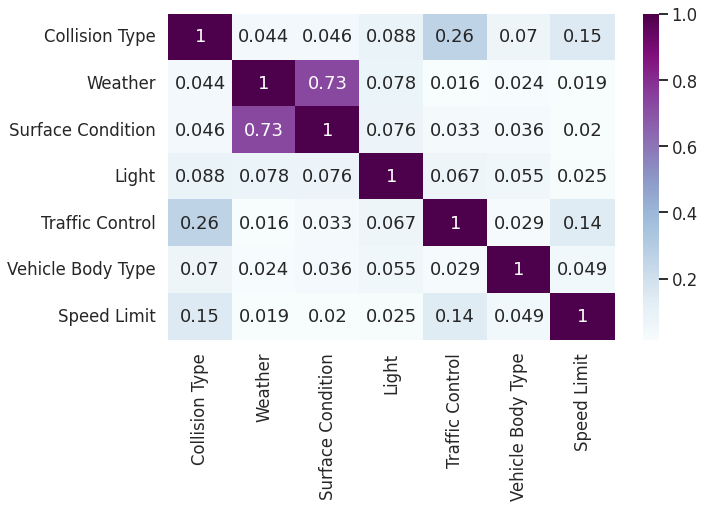

In [ ]:
def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x,y)
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
  rcorr = r-((r-1)**2)/(n-1)
  kcorr = k-((k-1)**2)/(n-1)
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


xs = np.array(['Collision Type','Weather','Surface Condition','Light','Traffic Control','Vehicle Body Type','Speed Limit'])
n = len(xs)
cor_mtx = np.zeros([n, n])
for i in range(n):
  for j in range(n):
    cor_mtx[i,j] = cramers_v(df[xs[i]], df[xs[j]])

sns.heatmap(cor_mtx, xticklabels=xs, yticklabels=xs, annot=True, cmap="BuPu");

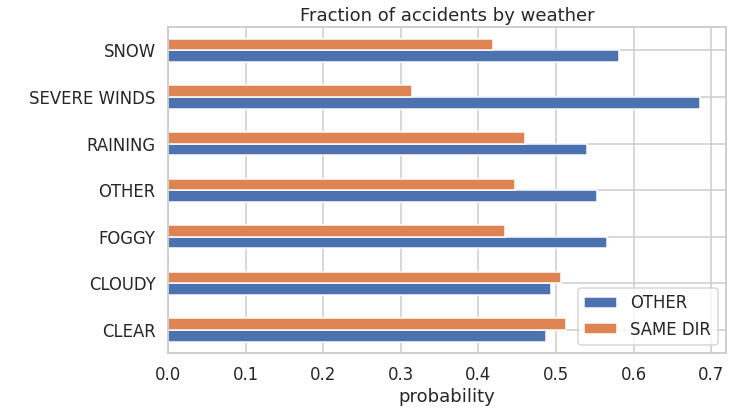

In [ ]:
tb1 = pd.crosstab(df['Weather'], df['Collision Type'], normalize='index')
tb1.plot.barh()
plt.legend(loc='lower right')
plt.title('Fraction of accidents by weather')
plt.xlabel('probability')
plt.ylabel(' ');

From this graph, we can conclude that other types of accidents occurred more than same direction crashes for most weather conditions. However, we should remember that `CLEAR` weather was the most prominent condtion, and there were slightly more same direction crashes in this category.

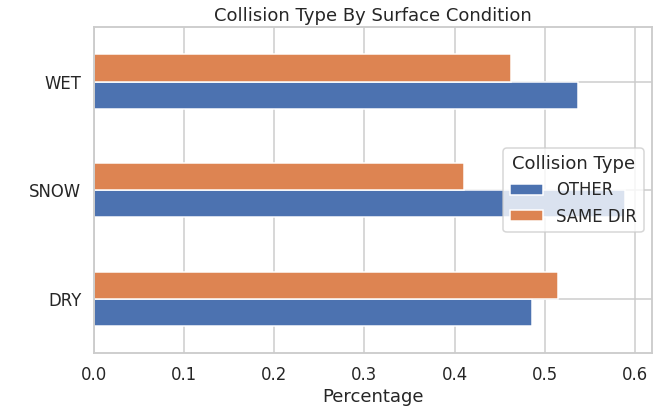

In [ ]:
pd.crosstab(df['Surface Condition'], df['Collision Type'], normalize='index').plot.barh()
plt.title('Collision Type By Surface Condition')
plt.xlabel('Percentage')
plt.ylabel(' ');

This plot displays the counts of accidents that occurred when the surface conditions were dry, snow and wet. Each category is displays two bars, one for each collision type we will be investigating. We can also see that the most accidents happened when the ground was dry, and a majority of those accidents were from the same direction.

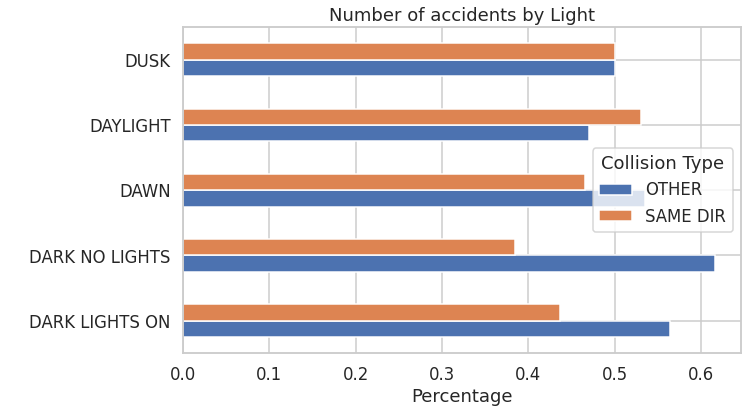

In [ ]:
pd.crosstab(df['Light'], df['Collision Type'], normalize='index').plot.barh()
plt.title("Number of accidents by Light")
plt.xlabel('Percentage')
plt.ylabel(' ');

We can conclude that most accidents occurred in `DAYLIGHT`, with `DARK LIGHTS ON` having a significant count as well.

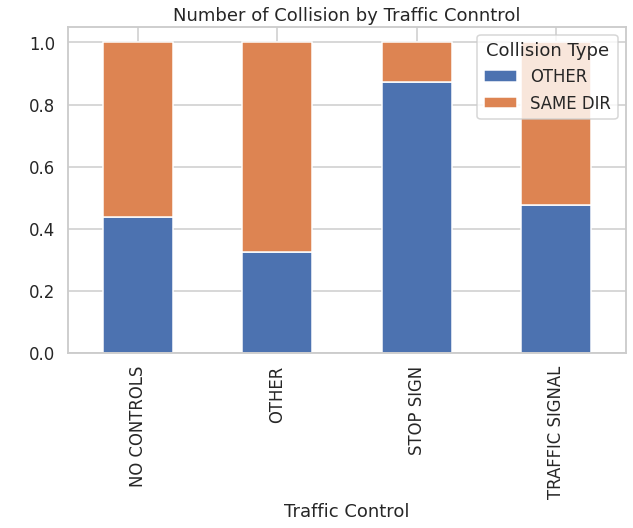

In [ ]:
pd.crosstab(df['Traffic Control'], df['Collision Type'], normalize='index').plot.bar(stacked=True)
plt.title('Number of Collision by Traffic Conntrol')
plt.ylabel('Percentage')
plt.ylabel(' ');

We can say that most accidents occured when there was no `Traffic Control`, followed by accidents near a `TRAFFIC SIGNAL` when the cars were driving in same direction.

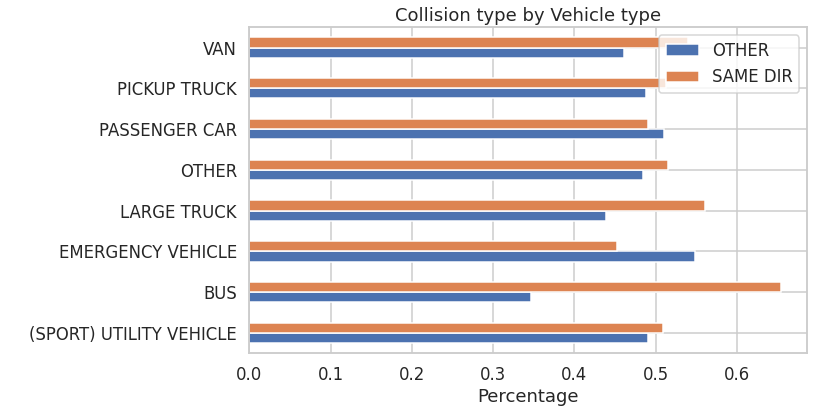

In [ ]:
tb2 = pd.crosstab(df['Vehicle Body Type'], df['Collision Type'], normalize='index')
tb2.plot.barh()
plt.legend(loc='upper right')
plt.title('Collision type by Vehicle type')
plt.xlabel('Percentage')
plt.ylabel(' ');

We can clearly see that many accidents occurred when the vehicles were moving in the same direction, and the types of vehicles that got into accidents most were the categories `BUS`, `LARGE TRUCK`, and `VAN`.

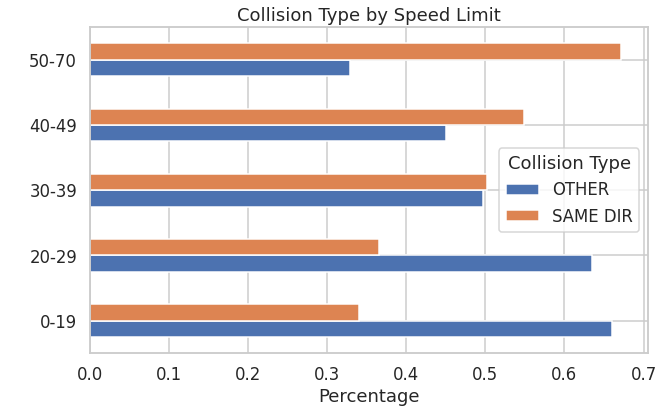

In [ ]:
pd.crosstab(df['Speed Limit'], df['Collision Type'], normalize='index').plot.barh()
plt.title('Collision Type by Speed Limit')
plt.xlabel('Percentage')
plt.ylabel(' ');

Finally, we can observe that accidents typically occurred when the speed limit was between 30-40 mph. 30-40mph is an average speed limit, so it makes sense that a lot of accidents would happen on roads in this range of limits.

## Machine Learning

Before we can begin the machine learning process, we need to convert all the predictor variables to numeric values. Each of these new features will provide possible splits to our tree classifier.

In [ ]:
target = 'Collision Type'
predictors = list(df.columns)
predictors.remove(target)
df_conversion = pd.get_dummies(df[predictors], drop_first=True)
df_conversion[target] = df[target]
df = df_conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103428 entries, 3 to 150893
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Weather_CLOUDY                       103428 non-null  uint8 
 1   Weather_FOGGY                        103428 non-null  uint8 
 2   Weather_OTHER                        103428 non-null  uint8 
 3   Weather_RAINING                      103428 non-null  uint8 
 4   Weather_SEVERE WINDS                 103428 non-null  uint8 
 5   Weather_SNOW                         103428 non-null  uint8 
 6   Surface Condition_SNOW               103428 non-null  uint8 
 7   Surface Condition_WET                103428 non-null  uint8 
 8   Light_DARK NO LIGHTS                 103428 non-null  uint8 
 9   Light_DAWN                           103428 non-null  uint8 
 10  Light_DAYLIGHT                       103428 non-null  uint8 
 11  Light_DUSK                

Next we need to split our data into training and testing data. Our target variable will be `Collision Type` and all other variables will be predictors.

In [ ]:
predictors = list(df.columns)
predictors.remove(target)

X = df[predictors].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=0)

print(X_train.shape)
print(y_train.shape)

(20685, 26)
(20685,)


Next we will calculate the baseline accuracy. Since we are trying to classify the accident as a same direction collision or not, this accuracy tells us our accuracy if we only guessed the majority value.

In [ ]:
acc = pd.Series(y_train).mode()[0]
print('Baseline accuracy: {:.3f}'.format((y_train == acc).mean()))

Baseline accuracy: 0.500


Now we need to create our model for the classification tree. Let's use a max depth of 8 to overfit our data.

In [ ]:
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X_train, y_train)
print('{:.3f}'.format(clf.score(X_train, y_train)))

0.620


When using a decision tree classifier with a depth of 8, we find that the resulting score is about 0.62.

Using the clf which was defined above with the collision types `OTHER` and `SAME DIR`, we get a cross validation accuracy of 60.5%, which is 10.5% more accurate than what was used previously.

In [ ]:
res = cross_val_score(clf, X_train, y_train, cv=20).mean()
print('Cross-validation accuracy: {:.3f}'.format(res))

Cross-validation accuracy: 0.605


Here we can observe the learning curve to find whether we achieved high bias or high variance. With the accuracy only being about 0.01-0.02 off after a training set size of around 6000, we might have high bias, but it should be ok to continue from this.

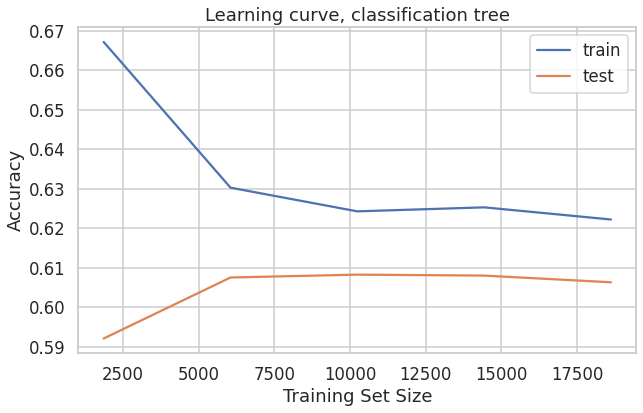

In [ ]:
plot_learning_curve(clf, X_train, y_train)

Next, let's perform hyperparameter turning to adjust the classification tree. We saw that a max depth of 8 gave us a pretty reasonable learning curve, so let's have our range of depths go from 2-8.

In [ ]:
tree_cv = GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),param_grid=[{'max_depth': range(2, 9),'max_features': ['sqrt', None],'min_samples_leaf': range(10, 50, 10)}],scoring='accuracy')
tree_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(2, 9),
                          'max_features': ['sqrt', None],
                          'min_samples_leaf': range(10, 50, 10)}],
             scoring='accuracy')

The best parameters for this tree appear to be a max depth of 8 and minimum samples per leaf of 40.

In [ ]:
print(tree_cv.best_params_)

{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 20}


The best cross validation accuracy from this grid search appears to be 60.6%, which still seems pretty reasonable.

In [ ]:
print('Top accuracy from grid search: {:.3f}'.format(tree_cv.best_score_))

Top accuracy from grid search: 0.607


Plotting the learning curve for the tuned tree shows us a slightly more biased curve, but at least they don't get close to overlapping at any point.

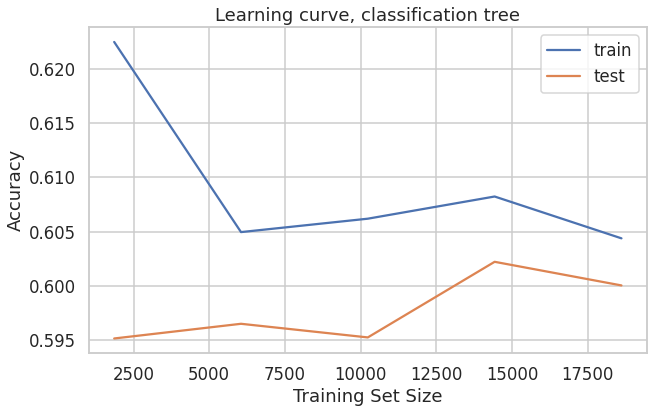

In [ ]:
plot_learning_curve(tree_cv.best_estimator_, X_train,y_train)

We can also observe the decisions that the tuned tree used.

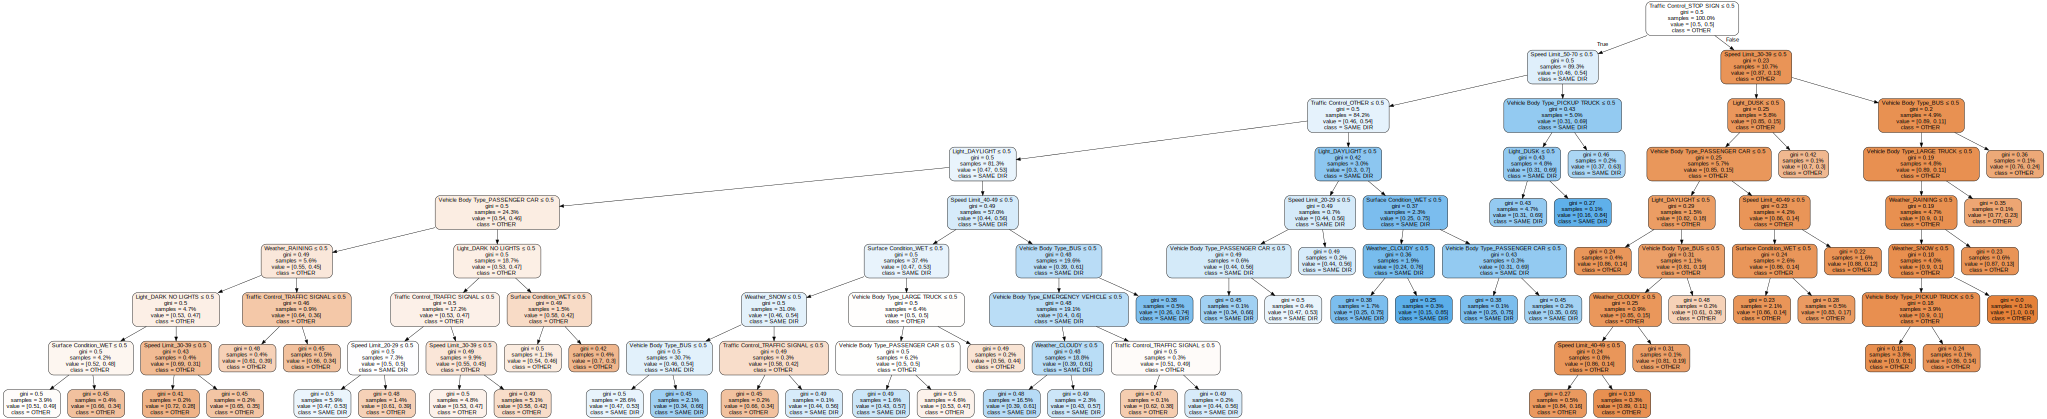

In [ ]:
plot_tree_custom(tree_cv.best_estimator_)

Now that we have a trained classification tree, we can find the importance of each feature. Let's look at which features were most important.

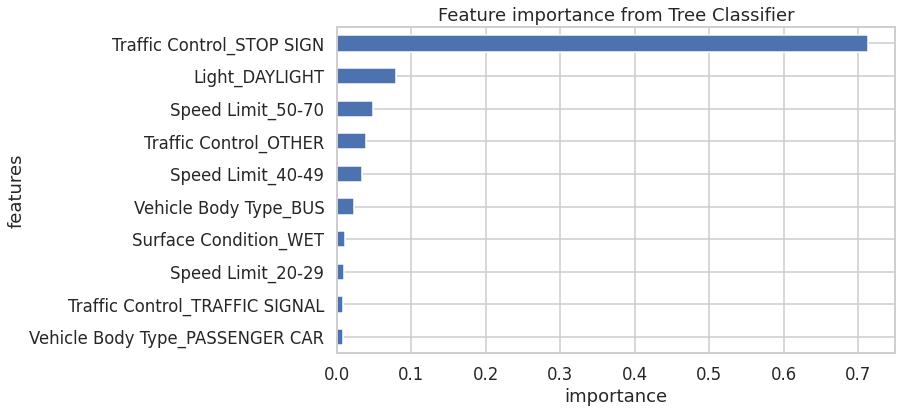

In [ ]:
temp_df = df.drop('Collision Type', axis=1)
feature_series = pd.Series(tree_cv.best_estimator_.feature_importances_, index=temp_df.columns)
feature_series.sort_values(ascending=False).head(10).sort_values().plot.barh()
plt.title('Feature importance from Tree Classifier')
plt.xlabel('importance')
plt.ylabel('features');

There is a significant difference in importance between the `STOP SIGN` variable and everything else. It is the definitive most important feature.

Now let's perform forward feature selection and plot the best accuracies. We can also print them out to see the exact values we obtained.

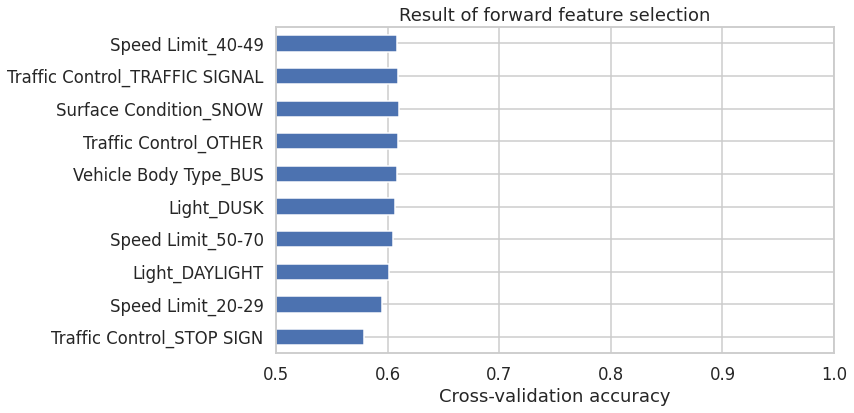

In [ ]:
selected, accuracies = forward_selection_classif(tree_cv.best_estimator_, X_train, y_train, num_folds=10)
plot_selected(selected[:10], accuracies[:10], np.array(predictors))

In [ ]:
print(np.array(accuracies[:10]).round(4))

[0.5784 0.5948 0.6008 0.6045 0.6064 0.608  0.6093 0.6097 0.6094 0.6087]


All that's left to do is check how our classifier does on data it's never seen before, so let's pass in the test data.

In [ ]:
res = tree_cv.best_estimator_.score(X_test, y_test)
print('test accuracy: {:.3f}'.format(res))

test accuracy: 0.599


## Conclusions

We created a classification tree classifier to predict whether a car accident would be a Same Direction crash or some other type of crash, based on predictor variables such as Vehicle Body Type, Speed Limit, Weather, and other factors. If we were just randomly guessing, or only predicting that we would not have a same direction crash outcome, we would predict correctly about 50% of the time. Our classifier's test accuracy rose to about 61%, which is a significant increase in prediction accuracy.

The most interesting part of this experience was figuring out how to process such a large amount of data. Working with over 100,000 rows can be super useful, but really difficult if we can't classify it properly. One observation I made from this was that the difference between a 20/80 split for train/test data, and a 70/30 split produced nearly identical results.

Our classifier ended up making a lot of choices I would not have expected. For one thing, Stop Signs were by far the more important feature for splitting this data. I think this is really meaningful because we can infer that same direction collisions are not likely to happen at stop signs, so more research into this may be warranted. I was also surprised that it took 8 decisions to reach a result, and it makes me wonder whether including more branches would even help improve the classifier.